<a href="https://colab.research.google.com/github/jjjjhs/project_cnn_diffusion/blob/deeplabv3/DEEPLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab 세팅 셀 (필수 라이브러리 + GPU 확인)

In [ ]:
# ✅ 필수 라이브러리 설치 (처음 1번만 실행)
!pip install torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil

# 원본 마스크 폴더 (굵게 만든 버전)
source_mask_dir = "/content/drive/MyDrive/swProject/mask_all"

# 대상 마스크 폴더들
target_mask_dirs = [
    "/content/drive/MyDrive/swProject/dataset/train/masks",
    "/content/drive/MyDrive/swProject/dataset/val/masks",
    "/content/drive/MyDrive/swProject/dataset/test/masks"
]

# 덮어쓰기 실행
for target_dir in target_mask_dirs:
    for fname in os.listdir(target_dir):
        if fname.endswith("_mask.png"):
            src_path = os.path.join(source_mask_dir, fname)
            dst_path = os.path.join(target_dir, fname)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)

print("✅ 마스크 이미지 덮어쓰기 완료!")


✅ 마스크 이미지 덮어쓰기 완료!


In [ ]:
# ✅ GPU 및 라이브러리 import
import random
import torch
import time
import os
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
import pickle
import pandas as pd

# 데이터셋 경로 설정
base_dir = "/content/drive/MyDrive/swProject/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# 각 클래스별 이미지 경로 설정
train_normal_dir = os.path.join(train_dir, "normal")
train_damaged_dir = os.path.join(train_dir, "damaged")
train_mask_dir = os.path.join(train_dir, "masks")

val_normal_dir = os.path.join(val_dir, "normal")
val_damaged_dir = os.path.join(val_dir, "damaged")
val_mask_dir = os.path.join(val_dir, "masks")

test_normal_dir = os.path.join(test_dir, "normal")
test_damaged_dir = os.path.join(test_dir, "damaged")
test_mask_dir = os.path.join(test_dir, "masks")

In [ ]:
#@
class LaneDataset(Dataset):
    def __init__(self, normal_dir, damaged_dir, mask_dir, transform=None, max_samples=None, seed=42):
        self.normal_images = sorted([f for f in os.listdir(normal_dir) if f.endswith(".jpg")])
        self.damaged_images = sorted([f for f in os.listdir(damaged_dir) if f.endswith(".jpg")])
        self.mask_images = sorted([f for f in os.listdir(mask_dir) if f.endswith("_mask.png")])

        self.normal_dir = normal_dir
        self.damaged_dir = damaged_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 전체 이미지 묶기
        self.all_images = list(zip(self.normal_images, ["normal"] * len(self.normal_images))) + \
                          list(zip(self.damaged_images, ["damaged"] * len(self.damaged_images)))

        # 샘플 제한 적용
        if max_samples is not None:
            random.seed(seed)
            normal_images = [x for x in self.all_images if x[1] == "normal"]
            damaged_images = [x for x in self.all_images if x[1] == "damaged"]

            # 비율 유지한 샘플링
            normal_num = int(max_samples * 0.7)
            damaged_num = max_samples - normal_num

            self.all_images = random.sample(normal_images, normal_num) + \
                              random.sample(damaged_images, damaged_num)
            random.shuffle(self.all_images)

    def __getitem__(self, idx):
        image_name, label = self.all_images[idx]
        img_path = os.path.join(self.normal_dir if label == "normal" else self.damaged_dir, image_name) # nomal, damaged 이미지 섞기

        mask_name = image_name.replace(".jpg", "_mask.png")
        mask_path = os.path.join(self.mask_dir, mask_name)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            img = self.transform(img)

        # 마스크 사이즈 960*540
        mask = mask.resize((960, 540))
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)
        mask = torch.from_numpy(mask).long()

        return img, mask

    def __len__(self):
        return len(self.all_images)

In [ ]:
# ✅ 변환 정의
# 좌우 반전, 밝기/채도 변화, 회전 -> 학습 일반화
transform = transforms.Compose([
    transforms.Resize((540, 960)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
# ✅ 실험할 하이퍼파라미터 조합
lr = 0.0001
weight = [1.0, 5.0]
batch_size = 4
num_epochs = 50

# ✅ 결과 저장용 리스트
#results = []

# 학습/검증/테스트 데이터셋 준비
train_dataset = LaneDataset(train_normal_dir, train_damaged_dir, train_mask_dir, transform)
val_dataset = LaneDataset(val_normal_dir, val_damaged_dir, val_mask_dir, transform)
test_dataset = LaneDataset(test_normal_dir, test_damaged_dir, test_mask_dir, transform)

# # @@@ 1000장만
# # 총 1000장 기준 분할
# train_dataset = LaneDataset(train_normal_dir, train_damaged_dir, train_mask_dir, transform, max_samples=700)
# val_dataset = LaneDataset(val_normal_dir, val_damaged_dir, val_mask_dir, transform, max_samples=200)
# test_dataset = LaneDataset(test_normal_dir, test_damaged_dir, test_mask_dir, transform, max_samples=100)


# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

#기존 train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#기존 val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# 모델 준비: DeepLabV3 모델 사용(백본: ResNet50)
model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1) # 클래스 수: 2(차선/차선아닌영역) (출력 채널 2개)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu 사용 못하면 cpu
model = model.to(device)

# Adam 옵티마이저 사용
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# ReduceLROnPlateau: val loss 기준으로 자동 학습률 감소
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# 손실 함수: CrossEntropy + Dice Loss -> 픽셀 단위 정확도와 세그멘테이션 경계 정확도를 동시에
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)[:,1,:,:]  # class=1만 추출 -> 차선에 대해서만 Dice 적
        targets = (targets == 1).float()
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

dice_loss = DiceLoss()
loss_fn = lambda outputs, masks: 0.3 * nn.CrossEntropyLoss(weight=torch.tensor(weight, dtype=torch.float).to(device))(outputs, masks) + \
                                 0.7 * dice_loss(outputs, masks)

# Early Stopping 설정 (10회 이상 loss가 더 작은 값이 안 나오면 학습 중단)
best_val_loss = float('inf')
patience = 10
counter = 0

# 로그 저장 리스트(학습 과정 추적용)
train_loss_history = []
val_loss_history = []

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 181MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torch.cuda.amp import GradScaler, autocast
scaler = torch.cuda.amp.GradScaler() # 혼합 정밀도 학습(AMP)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        # 혼합 정밀도 학습(AMP) + Optimizer & Scheduler
        with torch.cuda.amp.autocast():  # forward + loss 계산을 autocast 안에서
          outputs = model(images)["out"]
          loss = loss_fn(outputs, masks)

        #outputs = model(images)["out"]
        #loss = loss_fn(outputs, masks)
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        #train_loss += loss.item()

        scaler.scale(loss).backward()  # loss.backward() 대신
        scaler.step(optimizer)         # optimizer.step() 대신
        scaler.update()                # 스케일러 업데이트

        train_loss += loss.item()
        #last_train_loss = loss.item()  # 매 batch마다 덮어씀 (마지막 batch loss만 남음)
        #train_loss_history.append(last_train_loss)  # 최종 batch loss만 기록

    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    # 🔽 스케줄러 step 호출
    scheduler.step(avg_val_loss)

    #print(f"Epoch {epoch+1} - Train Loss: {last_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    checkpoint_path = f"/content/drive/MyDrive/swProject/checkpoint.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler': scaler.state_dict(),  # AMP 사용 시
        'best_val_loss': best_val_loss,
        'counter': counter,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
    }, checkpoint_path) # 중간 상태 저장 -> 중단 후 재개 가능

    # Early Stopping 체크
    if avg_val_loss < best_val_loss - 0.01:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # epoch 끝날 때 추가
    with open(f"/content/drive/MyDrive/swProject/loss_lr{lr}_w{weight[0]}-{weight[1]}_bs{batch_size}_epoch{epoch+1}.pkl", "wb") as f:
      pickle.dump({
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history}, f)

<ipython-input-9-da5ce702dec8>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # 혼합 정밀도 학습(AMP)
Epoch 1 - Train:   0%|          | 0/875 [00:00<?, ?it/s]<ipython-input-9-da5ce702dec8>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # forward + loss 계산을 autocast 안에서
Epoch 1 - Validation: 100%|██████████| 250/250 [05:02<00:00,  1.21s/it]


Epoch 1 - Train Loss: 0.4407 - Val Loss: 0.3960


Epoch 2 - Validation: 100%|██████████| 250/250 [03:21<00:00,  1.24it/s]


Epoch 2 - Train Loss: 0.3563 - Val Loss: 0.3545


Epoch 3 - Validation: 100%|██████████| 250/250 [03:21<00:00,  1.24it/s]


Epoch 3 - Train Loss: 0.3255 - Val Loss: 0.3267


Epoch 4 - Validation: 100%|██████████| 250/250 [03:21<00:00,  1.24it/s]


Epoch 4 - Train Loss: 0.3028 - Val Loss: 0.3202


Epoch 5 - Validation: 100%|██████████| 250/250 [03:21<00:00,  1.24it/s]


Epoch 5 - Train Loss: 0.2882 - Val Loss: 0.2990


Epoch 6 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.24it/s]


Epoch 6 - Train Loss: 0.2740 - Val Loss: 0.2888


Epoch 7 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 7 - Train Loss: 0.2625 - Val Loss: 0.2745


Epoch 8 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.24it/s]


Epoch 8 - Train Loss: 0.2559 - Val Loss: 0.2683


Epoch 9 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.24it/s]


Epoch 9 - Train Loss: 0.2449 - Val Loss: 0.2611


Epoch 10 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 10 - Train Loss: 0.2414 - Val Loss: 0.2632


Epoch 11 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.24it/s]


Epoch 11 - Train Loss: 0.2341 - Val Loss: 0.2579


Epoch 12 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 12 - Train Loss: 0.2289 - Val Loss: 0.2502


Epoch 13 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 13 - Train Loss: 0.2213 - Val Loss: 0.2473


Epoch 14 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 14 - Train Loss: 0.2181 - Val Loss: 0.2416


Epoch 15 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 15 - Train Loss: 0.2131 - Val Loss: 0.2402


Epoch 16 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 16 - Train Loss: 0.2072 - Val Loss: 0.2401


Epoch 17 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 17 - Train Loss: 0.2029 - Val Loss: 0.2354


Epoch 18 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 18 - Train Loss: 0.1993 - Val Loss: 0.2286


Epoch 19 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 19 - Train Loss: 0.1964 - Val Loss: 0.2281


Epoch 20 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 20 - Train Loss: 0.1942 - Val Loss: 0.2190


Epoch 21 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 21 - Train Loss: 0.1881 - Val Loss: 0.2277


Epoch 22 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 22 - Train Loss: 0.1854 - Val Loss: 0.2185


Epoch 23 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 23 - Train Loss: 0.1816 - Val Loss: 0.2202


Epoch 24 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 24 - Train Loss: 0.1819 - Val Loss: 0.2151


Epoch 25 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 25 - Train Loss: 0.1780 - Val Loss: 0.2132


Epoch 26 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 26 - Train Loss: 0.1735 - Val Loss: 0.2158


Epoch 27 - Validation: 100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


Epoch 27 - Train Loss: 0.1725 - Val Loss: 0.2178


Epoch 28 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 28 - Train Loss: 0.1706 - Val Loss: 0.2134


Epoch 29 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 29 - Train Loss: 0.1663 - Val Loss: 0.2109


Epoch 30 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 30 - Train Loss: 0.1637 - Val Loss: 0.2056


Epoch 31 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 31 - Train Loss: 0.1623 - Val Loss: 0.2034


Epoch 32 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 32 - Train Loss: 0.1615 - Val Loss: 0.2106


Epoch 33 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 33 - Train Loss: 0.1589 - Val Loss: 0.2021


Epoch 34 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 34 - Train Loss: 0.1551 - Val Loss: 0.2011


Epoch 35 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 35 - Train Loss: 0.1527 - Val Loss: 0.2071


Epoch 36 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 36 - Train Loss: 0.1534 - Val Loss: 0.2007


Epoch 37 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 37 - Train Loss: 0.1517 - Val Loss: 0.2048


Epoch 38 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.26it/s]


Epoch 38 - Train Loss: 0.1486 - Val Loss: 0.2045


Epoch 39 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 39 - Train Loss: 0.1460 - Val Loss: 0.1984


Epoch 40 - Validation: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


Epoch 40 - Train Loss: 0.1427 - Val Loss: 0.1983
Early stopping at epoch 40


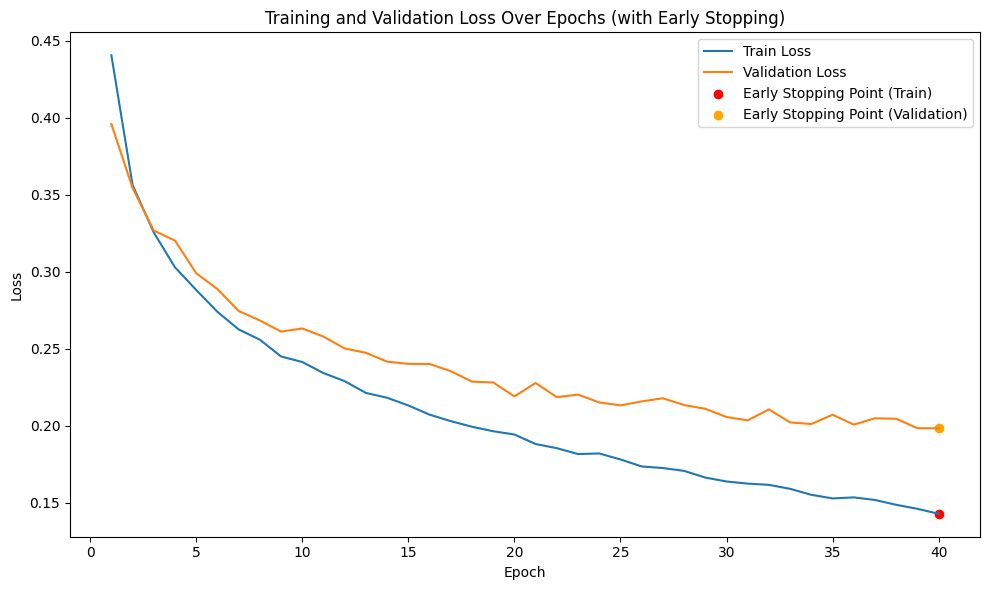

✅ 최종 학습 완료
✅ 모델 저장 완료!


In [ ]:
# 학습 결과 손실 그래프 저장 및 출력
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label='Validation Loss')
# Early Stopping 지점 강조
plt.scatter(len(train_loss_history), train_loss_history[-1], color='red', label='Early Stopping Point (Train)')
plt.scatter(len(val_loss_history), val_loss_history[-1], color='orange', label='Early Stopping Point (Validation)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs (with Early Stopping)")
plt.legend()
plt.tight_layout()
plt.savefig("final_loss_curve.png")
plt.show()

print("✅ 최종 학습 완료")

# 최종 학습 완료된 모델 저장
model_path = f"/content/drive/MyDrive/final_model_lr{lr}_bs{batch_size}_ep{epoch+1}.pth"
torch.save(model.state_dict(), model_path)
print("✅ 모델 저장 완료!")

In [ ]:
# 테스트 세트 평가: Dice Similarity Coefficient (DSC)
# argmax로 예측 마스크 생성 후 DSC 계산
def dice_coefficient(pred_mask, true_mask, smooth=1e-6):
    pred_mask = (pred_mask > 0.5).float()  # 확실하게 binarize
    true_mask = (true_mask > 0.5).float()  # 확실하게 binarize
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def iou_score(pred_mask, true_mask, smooth=1e-6):
    pred_mask = (pred_mask > 0.5).float()
    true_mask = (true_mask > 0.5).float()
    intersection = (pred_mask * true_mask).sum()
    union = ((pred_mask + true_mask) > 0).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

# 평가 실행
model.eval()
dsc_scores = []
iou_scores = []
image_metrics = []

# 평균 및 표준편차 출력 + CSV 저장
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing (DSC Evaluation)"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1)

        for i, (pred_mask, true_mask) in enumerate(zip(preds, masks)):
            dsc = dice_coefficient(pred_mask, true_mask)
            iou = iou_score(pred_mask, true_mask)
            dsc_scores.append(dsc)
            iou_scores.append(iou)
            image_metrics.append({
                "Index": len(dsc_scores),  # 또는 실제 이미지 이름
                "DSC": dsc,
                "IoU": iou
            })

# 평균 및 표준편차 출력
mean_dsc = np.mean(dsc_scores)
std_dsc = np.std(dsc_scores)
mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)

# 결과 출력
print(f"테스트 세트 결과:")
print(f"- 평균 DSC: {mean_dsc:.4f} ± {std_dsc:.4f}")
print(f"- 평균 IoU: {mean_iou:.4f} ± {std_iou:.4f}")

# 요약 결과 CSV 저장
summary_df = pd.DataFrame({
    'Metric': ['Mean DSC', 'Standard Deviation DSC', 'Mean IoU', 'Standard Deviation IoU'],
    'Value': [mean_dsc, std_dsc, mean_iou, std_iou]
})
summary_df.to_csv("/content/drive/MyDrive/test_summary_metrics.csv", index=False)
print("✅ 평균/표준편차 결과 저장 완료")

# 개별 이미지별 결과 CSV 저장
detailed_df = pd.DataFrame(image_metrics)
detailed_df.to_csv("/content/drive/MyDrive/test_detailed_metrics.csv", index=False)
print("✅ 이미지별 DSC/IoU 결과 저장 완료")

Testing (DSC Evaluation): 100%|██████████| 125/125 [02:45<00:00,  1.32s/it]


테스트 세트 결과:
- 평균 DSC: 0.6903 ± 0.1928
- 평균 IoU: 0.5554 ± 0.1953
✅ 평균/표준편차 결과 저장 완료
✅ 이미지별 DSC/IoU 결과 저장 완료


In [ ]:
# 분류 성능 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def mask_to_label(mask):
    """마스크에 class 1이 하나라도 있으면 손상(1), 아니면 정상(0)"""
    return 1 if (mask > 0).any() else 0

def evaluate_classification_metrics(model, dataloader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating Classification Metrics"):
            images = images.to(device)
            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1).cpu()

            for pred_mask, true_mask in zip(preds, masks):
                pred_label = mask_to_label(pred_mask)
                true_label = mask_to_label(true_mask)
                pred_labels.append(pred_label)
                true_labels.append(true_label)

    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average="binary")
    rec = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print("\n📊 Classification Metrics on Test Set")
    print(f"▶ Accuracy : {acc:.4f}")
    print(f"▶ Precision: {prec:.4f}")
    print(f"▶ Recall   : {rec:.4f}")
    print(f"▶ F1-Score : {f1:.4f}")

    print("\n📊 Classification Report (sklearn)")
    print(classification_report(true_labels, pred_labels, digits=4))

    return acc, prec, rec, f1

evaluate_classification_metrics(model, test_loader, device)

Evaluating Classification Metrics: 100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


📊 Classification Metrics on Test Set
▶ Accuracy : 0.8860
▶ Precision: 0.9977
▶ Recall   : 0.8873
▶ F1-Score : 0.9393

📊 Classification Report (sklearn)
              precision    recall  f1-score   support

           0     0.0345    0.6667    0.0656         3
           1     0.9977    0.8873    0.9393       497

    accuracy                         0.8860       500
   macro avg     0.5161    0.7770    0.5024       500
weighted avg     0.9920    0.8860    0.9341       500



(0.886, 0.997737556561086, 0.8873239436619719, 0.939297124600639)

모델 불러오가 + 오버레이

In [1]:
import os
import glob
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import models, transforms
import cv2

# 모델 정의
# model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
model = models.segmentation.deeplabv3_resnet50(weights=None, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
#state_dict = torch.load("/content/drive/MyDrive/final_model.pth")
# for key in list(state_dict.keys()):
#     if "classifier.4" in key:
#         del state_dict[key]
# model.load_state_dict(state_dict, strict=False)
model.load_state_dict(torch.load("/content/drive/MyDrive/final_model.pth"))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# transform (정규화 제거)
transform = transforms.Compose([
    transforms.Resize((540, 960)),
    transforms.ToTensor()
])

# 랜덤 이미지 및 마스크 가져오기
def get_random_image_and_mask(image_dir, mask_dir):
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.*')))
    selected_image = random.choice(image_files)
    image_name = os.path.basename(selected_image)
    base_name = os.path.splitext(image_name)[0]
    mask_name = f"{base_name}_mask.png"
    mask_path = os.path.join(mask_dir, mask_name)

    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask not found for {selected_image}")
    return selected_image, mask_path

# 예측 및 시각화
def visualize_prediction_and_overlay(model, image_path, mask_path):
    # 이미지 준비
    image = Image.open(image_path).convert("RGB")
    input_resized = image.resize((960, 540))
    image_tensor = transform(input_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)["out"]
        softmax_probs = torch.softmax(output, dim=1)
        pred = (softmax_probs[:, 1, :, :] > 0.3).cpu().numpy().squeeze().astype(np.uint8)

    # 🔽 예측 마스크 후처리: 침식 (얇게)
    # closing으로 경계 연결 + 중심 메꿈
    # Closing: 끊긴 라인 연결
    # kernel = np.ones((3, 3), np.uint8)
    # pred = cv2.morphologyEx(pred, cv2.MORPH_CLOSE, kernel)

    # # 예측 마스크 업데이트
    # pred = filled_pred

    # 1. 경계 연결 (작은 커널 사용)
    kernel = np.ones((2, 2), np.uint8)  # 기존 3x3 or 7x7보다 작게
    pred = cv2.morphologyEx(pred, cv2.MORPH_CLOSE, kernel)

    # 2. 윤곽선 기반 중심 채우기
    contours, _ = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 작은 윤곽선은 무시하고, 얇게 유지
    filled_pred = np.zeros_like(pred)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100:  # 너무 얇거나 노이즈는 무시
            cv2.drawContours(filled_pred, [cnt], -1, 1, thickness=cv2.FILLED)

    pred = filled_pred

    # GT 마스크 준비
    gt_mask = Image.open(mask_path).convert("L").resize((960, 540))
    gt = (np.array(gt_mask) > 127).astype(np.uint8)

    # TP, FP, FN
    TP = (pred == 1) & (gt == 1)
    FP = (pred == 1) & (gt == 0)
    FN = (pred == 0) & (gt == 1)

    # 오버레이 이미지 만들기
    overlay = np.array(input_resized).copy()
    overlay[TP] = [255, 0, 0]    # 빨간색 (True Positive)
    overlay[FP] = [0, 255, 0]    # 초록색 (False Positive)
    overlay[FN] = [0, 0, 255]    # 파란색 (False Negative)

    # 시각화
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(input_resized)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Processed Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Overlay: TP=Red, FP=Green, FN=Blue")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_multiple_predictions(model, image_dir, mask_dir, num_samples=10):
      image_files = sorted(glob.glob(os.path.join(image_dir, '*.*')))
      selected_files = random.sample(image_files, min(num_samples, len(image_files)))

      for img_path in selected_files:
          image_name = os.path.basename(img_path)
          base_name = os.path.splitext(image_name)[0]
          mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

          if not os.path.exists(mask_path):
              print(f"[경고] 마스크 없음: {img_path}")
              continue

          print(f"[시각화 중] {img_path}")
          visualize_prediction_and_overlay(model, img_path, mask_path)

# ✅ 실행
print("▶ 손상 이미지 10장 시각화")
visualize_multiple_predictions(model, test_damaged_dir, test_mask_dir, num_samples=10)

print("▶ 정상 이미지 10장 시각화")
visualize_multiple_predictions(model, test_normal_dir, test_mask_dir, num_samples=10)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


NameError: name 'nn' is not defined

In [ ]:
# import os
# os.kill(os.getpid(), 9)  # 현재 프로세스 강제 종료


In [ ]:
# @title
# import os
# import glob
# import random
# import torch
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np

# # 모델 구조 정의
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)

# # 모델의 출력 클래스 수를 2로 설정
# model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

# # 모델 가중치 불러오기 (strict=False로 불일치 부분 무시)
# state_dict = torch.load("/content/drive/MyDrive/final_model.pth")

# # 출력 레이어만 제외한 가중치 로딩
# for key in list(state_dict.keys()):
#     if "classifier.4" in key:
#         del state_dict[key]

# model.load_state_dict(state_dict, strict=False)  # strict=False로 불일치 무시

# # 모델을 평가 모드로 설정
# model.eval()

# # 모델을 GPU로 올리기
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# def get_random_image_and_mask(image_dir, mask_dir):0
#     image_files = sorted(glob.glob(os.path.join(image_dir, '*.*')))
#     selected_image = random.choice(image_files)
#     image_name = os.path.basename(selected_image)
#     base_name = os.path.splitext(image_name)[0]
#     mask_name = f"{base_name}_mask.png"
#     mask_path = os.path.join(mask_dir, mask_name)

#     if not os.path.exists(mask_path):
#         raise FileNotFoundError(f"Mask not found for {selected_image}")

#     return selected_image, mask_path

# # Transform 적용
# transform = transforms.Compose([
#     transforms.Resize((720, 1080)),
#     transforms.ToTensor(),
# ])

# image_tensor = transform(image).unsqueeze(0).to(DEVICE)

# # 예측
# with torch.no_grad():
#     output = model(image_tensor)

# # 예측 결과에서 가장 높은 값의 클래스를 선택 (각 픽셀별로)
# predicted = torch.argmax(output['out'], dim=1).squeeze().cpu().numpy()

# # 원본 이미지 크기에 맞게 리사이즈
# resize_transform = transforms.Compose([
#     transforms.Resize((image.size[1], image.size[0]))  # 원본 이미지 크기로 리사이즈
# ])

# mask_resized = Image.fromarray(predicted.astype(np.uint8))
# mask_resized = resize_transform(mask_resized)
# mask_resized = np.array(mask_resized)

# # 시각화
# plt.figure(figsize=(10, 10))
# plt.subplot(1, 3, 1)
# plt.imshow(np.array(image))
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(mask_resized, cmap='tab20b')  # 예측된 마스크에 색상 맵 적용
# plt.title('Predicted Mask')
# plt.axis('off')

# # 오버레이
# plt.subplot(1, 3, 3)
# overlay = np.array(image).copy()

# # 예측된 마스크에서 차선(값이 255인 부분)을 찾아 흰색으로 오버레이
# overlay[mask_resized == 1] = [255, 255, 255]  # 차선 위치에 흰색 오버레이

# plt.imshow(overlay)
# plt.title('Overlay')
# plt.axis('off')

# plt.show()


In [ ]:
# @title
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from PIL import Image
# from torchvision import transforms
# import torch

# def predict_mask(model, image_path, device='cuda'):
#     model.eval()
#     image = Image.open(image_path).convert("RGB")

#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 기준
#                              std=[0.229, 0.224, 0.225])
#     ])

#     input_tensor = transform(image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         output = model(input_tensor)
#         if output.shape[1] == 1:  # binary segmentation
#             pred = torch.sigmoid(output).squeeze().cpu().numpy()
#             pred_mask = (pred > 0.5).astype(np.uint8)
#         else:  # multi-class
#             pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

#     return np.array(image), pred_mask

# def visualize_detection_result(model, image_path, gt_mask_path, device='cuda'):
#     # Load prediction and image
#     image_np, pred_mask = predict_mask(model, image_path, device)

#     # Load ground truth mask
#     gt_mask = Image.open(gt_mask_path).convert("L")
#     gt_mask = np.array(gt_mask)
#     if gt_mask.max() > 1:
#         gt_mask = (gt_mask > 127).astype(np.uint8)  # binarize if needed

#     # TP, FP, FN 계산
#     TP = (pred_mask == 1) & (gt_mask == 1)
#     FP = (pred_mask == 1) & (gt_mask == 0)
#     FN = (pred_mask == 0) & (gt_mask == 1)

#     overlay = image_np.copy()

#     # 색 오버레이
#     overlay[TP] = [255, 0, 0]    # 빨간색
#     overlay[FP] = [0, 255, 0]    # 녹색
#     overlay[FN] = [0, 0, 255]    # 파란색

#     # 시각화
#     plt.figure(figsize=(18, 6))

#     plt.subplot(1, 4, 1)
#     plt.imshow(image_np)
#     plt.title("Original Image")
#     plt.axis('off')

#     plt.subplot(1, 4, 2)
#     plt.imshow(gt_mask, cmap='gray')
#     plt.title("Ground Truth Mask")
#     plt.axis('off')

#     plt.subplot(1, 4, 3)
#     plt.imshow(pred_mask, cmap='gray')
#     plt.title("Predicted Mask")
#     plt.axis('off')

#     plt.subplot(1, 4, 4)
#     plt.imshow(overlay)
#     plt.title("Overlay: TP(R) FP(G) FN(B)")
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()


In [ ]:
# @title
# import torch
# from torchvision import models
# import torch.nn as nn

# # ✅ 모델 구조 다시 선언 (pretrained 로!)
# model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
# model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.load_state_dict(torch.load("/content/drive/MyDrive/final_model.pth", map_location=device))
# model = model.to(device)
# model.eval()

# print("✅ 모델 불러오기 완료!")


In [ ]:
# @title
# # @title 그리드 탐색 루프
# # ✅ 그리드 탐색 루프
# for lr, weight, bs in product(learning_rates, loss_weights, batch_sizes):
#     print(f"\n\n🚀 실험 시작: lr={lr}, weight={weight}, batch_size={bs}")

#     train_dataset = LaneDataset(image_dir, mask_dir, train_ids, transform)
#     val_dataset = LaneDataset(image_dir, mask_dir, val_ids, transform)

#     if len(train_dataset) == 0:
#         print("⚠️ 학습 데이터가 비어있어 건너뜁니다.")
#         continue

#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=bs)

#     model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
#     model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight, dtype=torch.float).to(device))

#     loss_history = []
#     num_epochs = 3

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#             images, masks = images.to(device), masks.to(device)
#             outputs = model(images)["out"]
#             loss = loss_fn(outputs, masks)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         avg_loss = total_loss / len(train_loader)
#         loss_history.append(avg_loss)
#         print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

#     # 결과 기록
#     results.append({
#         "lr": lr,
#         "weight": weight,
#         "batch_size": bs,
#         "loss_history": loss_history
#     })

# # ✅ 전체 실험 후 그래프 출력 및 최적 조합 찾기 (평균 loss 기준)
# import matplotlib.pyplot as plt
# import numpy as np

# plt.figure(figsize=(10, 6))
# for result in results:
#     lr = result["lr"]
#     weight = result["weight"]
#     bs = result["batch_size"]
#     loss_history = result["loss_history"]
#     label = f"lr={lr}, w={weight[0]}/{weight[1]}, bs={bs}"
#     plt.plot(range(1, len(loss_history)+1), loss_history, label=label)

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss Comparison for Hyperparameter Combinations")
# plt.legend(fontsize="small")
# plt.tight_layout()
# plt.savefig("loss_comparison_all.png")
# plt.show()

# # 평균 loss 기준 최적 조합 찾기
# best_result = min(results, key=lambda x: np.mean(x["loss_history"]))
# mean_loss = np.mean(best_result["loss_history"])

# print("✅ 최적 조합 (평균 loss 기준):")
# print(f"lr = {best_result['lr']}")
# print(f"weight = {best_result['weight']}")
# print(f"batch_size = {best_result['batch_size']}")
# print(f"평균 loss = {mean_loss:.4f}")